In [32]:
import os
os.chdir('/u/shenxi/frengression')
from frengression import *
import torch
from torch import nn
import matplotlib.pyplot as plt
# from data_causl.data_causl import generate_data_causl

device = torch.device('cuda:2')

In [26]:
import importlib
import frengression
importlib.reload(frengression)
from frengression import *

In [69]:
n = 10000
z = torch.randn(n, 1)
x = z + torch.randn(n, 1)
y = (2*x + torch.randn(n, 1)).pow(2)

In [70]:
x = x.to(device)
y = y.to(device)
z = z.to(device)

In [71]:
model = Frengression(1, 1, 1, noise_dim=1, num_layer=3, hidden_dim=400, device=device)

In [72]:
model.train_xz(x, z, num_iters=500, print_every_iter=100)

Epoch 1: loss 1.3945, loss1 1.4763, loss2 0.1635
Epoch 100: loss 1.0436, loss1 2.0810, loss2 2.0746
Epoch 200: loss 1.0247, loss1 2.0756, loss2 2.1019
Epoch 300: loss 1.0511, loss1 2.0664, loss2 2.0306
Epoch 400: loss 1.0359, loss1 2.0677, loss2 2.0638
Epoch 500: loss 1.0495, loss1 2.0842, loss2 2.0694


In [73]:
model.train_y(x, z, y, num_iters=2000, lr=1e-4, print_every_iter=100)

Epoch 1: loss 9.5523, loss_y 8.7810, 8.8111, 0.0601,                      loss_eta 0.7713, 0.7974, 0.0523
Epoch 100: loss 6.0413, loss_y 5.2490, 7.0661, 3.6344,                      loss_eta 0.7923, 2.1082, 2.6317
Epoch 200: loss 4.6899, loss_y 3.6893, 6.7079, 6.0373,                      loss_eta 1.0006, 2.2154, 2.4295
Epoch 300: loss 4.4769, loss_y 3.7073, 8.5396, 9.6646,                      loss_eta 0.7696, 2.2751, 3.0110
Epoch 400: loss 3.8925, loss_y 3.2266, 5.9362, 5.4193,                      loss_eta 0.6659, 1.5863, 1.8409
Epoch 500: loss 6.3200, loss_y 5.6655, 6.4633, 1.5957,                      loss_eta 0.6545, 1.3060, 1.3030
Epoch 600: loss 4.5758, loss_y 3.8945, 5.8952, 4.0016,                      loss_eta 0.6814, 1.6178, 1.8729
Epoch 700: loss 5.0751, loss_y 4.4792, 8.4665, 7.9745,                      loss_eta 0.5958, 1.3788, 1.5659
Epoch 800: loss 3.6022, loss_y 2.8943, 5.8994, 6.0101,                      loss_eta 0.7078, 0.9546, 0.4936
Epoch 900: loss 4.2506, loss_y

In [66]:
model.train_y(x, z, y, num_iters=1000, lr=1e-4, print_every_iter=100)

Epoch 1: loss 0.9356, loss_y 0.3486, 0.6666, 0.6358,                      loss_eta 0.5869, 1.3315, 1.4893
Epoch 100: loss 0.8541, loss_y 0.2920, 0.6572, 0.7305,                      loss_eta 0.5621, 1.2166, 1.3090
Epoch 200: loss 0.9051, loss_y 0.3184, 0.6627, 0.6886,                      loss_eta 0.5867, 1.1439, 1.1144
Epoch 300: loss 0.8747, loss_y 0.3028, 0.5573, 0.5090,                      loss_eta 0.5719, 1.1237, 1.1037
Epoch 400: loss 0.8806, loss_y 0.3026, 0.5400, 0.4747,                      loss_eta 0.5780, 1.1475, 1.1390
Epoch 500: loss 0.8897, loss_y 0.3142, 0.6330, 0.6375,                      loss_eta 0.5755, 1.1726, 1.1941
Epoch 600: loss 0.8603, loss_y 0.2885, 0.6351, 0.6931,                      loss_eta 0.5718, 1.2110, 1.2785
Epoch 700: loss 0.9075, loss_y 0.3394, 0.6308, 0.5827,                      loss_eta 0.5681, 1.2422, 1.3481
Epoch 800: loss 0.8621, loss_y 0.2955, 0.6228, 0.6546,                      loss_eta 0.5667, 1.1529, 1.1725
Epoch 900: loss 0.9116, loss_y

In [74]:
n_te = 1000
z_te = torch.randn(n_te, 1)
x_te = z_te + torch.randn(n_te, 1)
y_te = (2*x_te + torch.randn(n_te, 1))**2

In [75]:
y_pred_causal = model.predict_causal(x_te, sample_size=1000)

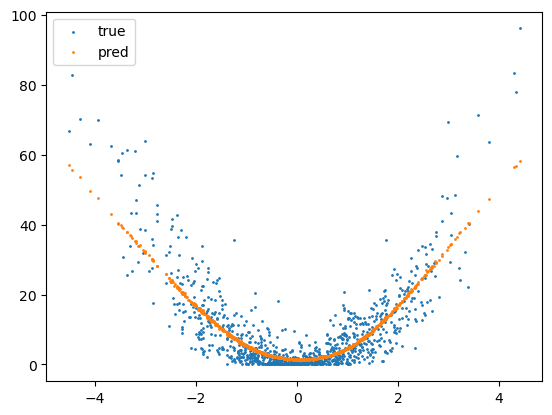

In [76]:
plt.scatter(x_te, y_te, s=1, label='true')
plt.scatter(x_te, y_pred_causal.cpu(), s=1, label='pred')
plt.legend(); plt.show()